# Maximum likelihood estimation for inhomogenous Poisson processes

We consider an inhomogenous Poisson process (IPP) $(X_t)_{t\geq 0}$, i.e., a stochastic process in continuous time exhibiting event times $0<T_1<T_2<T_3 <...$. Central to the analysis of an IPPs behavior is the time dependent intensity function, usually called $\lambda$, where $\lambda$ is a measurable function of $t\geq 0$ taking values in the non-negative real numbers, i.e., $$\lambda:[0,\infty)\to [0,\infty).$$
The intensity function can be locally understood as the inverse expected time between events such that at times $t\in[0,\infty)$ where $\lambda$ is large, event times $T_i<T_{i+1}<...<T_k$ may accumulate in a short time frame.

## Simulation of an IPP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

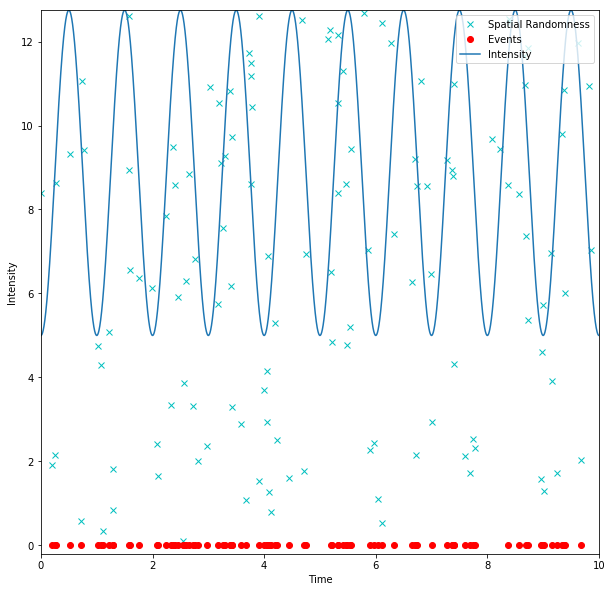

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fminbound, minimize 

# Setup for intensity function
param = [5,0.2]
a = 20
b = 25-a
flip = 1

if flip ==1:
    # interaction=0 in apoastron
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak * (np.sqrt(a**2-b**2) +  a - #apoastron (=no SPI)
                              np.sqrt( (np.sqrt(a**2-b**2) - a*np.cos(2*np.pi*(time-1/2)))**2 + 
                                        b**2*(np.sin(2*np.pi*(time-1/2))**2))) #distance planet-focal point(=star)
else:
    # interaction depends inversely on distance
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak / (np.sqrt((np.sqrt(a**2-b**2) - 
                                       a*np.cos(2*np.pi*(time-1/2)))**2 + 
                                      b**2*(np.sin(2*np.pi*(time-1/2))**2))) #interaction does not fall to zero

# Analyis of inhomogenity
maximum_of_inhomogenity = fminbound(lambda x: -inhomogenity(x, param[0], param[1]), 0, 1)
z = inhomogenity(maximum_of_inhomogenity, param[0], param[1])
t_max = 10
amount_of_dummy_realizations = int(t_max*z) + 1

# Create window to simulate IPP over 
X = np.random.rand(2, amount_of_dummy_realizations)
X = X[:,np.argsort(X[0,:])]
X[0,:] = X[0,:]*t_max
X[1,:] = X[1,:]*z 


hist = np.array([])
t_cur = 0

for item in X.T:
    if item[0] > t_cur:
        t_eval = item[0]
        if inhomogenity(t_eval, param[0],param[1]) > item[1]:
            hist = np.append(hist,t_eval)
            t_cur = t_eval
        else:
            t_cur = t_eval

# Plot samples and intensity function
time = np.append(np.linspace(0,t_max, 100000), hist)
time = np.sort(time)

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.plot(X[0,:], X[1,:], 'xc')
plt.plot(hist, np.zeros(len(hist)), 'ro')
plt.plot(time, inhomogenity(time, param[0], param[1]))
ax.set_xlim([0,t_max])
ax.set_ylim([-0.2,z])
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend(('Spatial Randomness', 'Events', 'Intensity'), loc = 1)
plt.show()

## Creating Data

In [3]:
# Setup for intensity function
if flip ==1:
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak*(np.sqrt(a**2-b**2) + a - np.sqrt((np.sqrt(a**2-b**2) - a*np.cos(2*np.pi*(time-1/2)))**2 + b**2*(np.sin(2*np.pi*(time-1/2))**2)))
else:
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak/(np.sqrt((np.sqrt(a**2-b**2) - a*np.cos(2*np.pi*(time-1/2)))**2 + b**2*(np.sin(2*np.pi*(time-1/2))**2)))

# Analyis of inhomogenity
maximum_of_inhomogenity = fminbound(lambda x: -inhomogenity(x, param[0], param[1]), 0, 1)
z = inhomogenity(maximum_of_inhomogenity, param[0], param[1])
amount_of_dummy_realizations = int(t_max*z) + 1

# Create window to simulate IPP over 
X = np.random.rand(2, amount_of_dummy_realizations)
X = X[:,np.argsort(X[0,:])]
X[0,:] = X[0,:]*t_max
X[1,:] = X[1,:]*z 


hist = np.array([])
t_cur = 0

for item in X.T:
    if item[0] > t_cur:
        t_eval = item[0]
        if inhomogenity(t_eval, param[0],param[1]) > item[1]:
            hist = np.append(hist,t_eval)
            t_cur = t_eval
        else:
            t_cur = t_eval


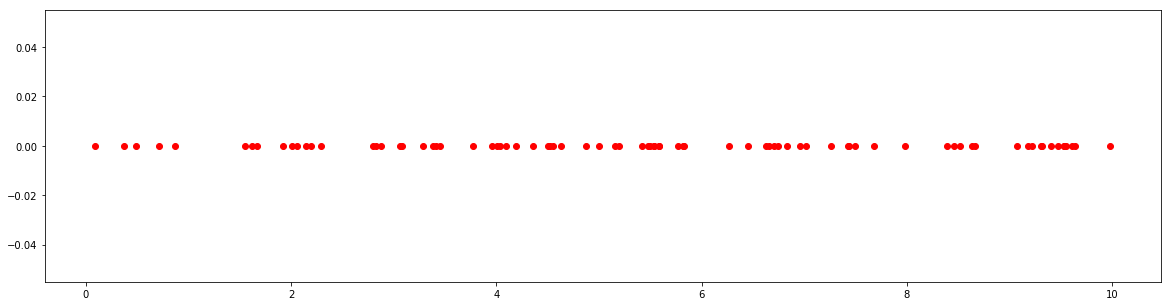

In [4]:
plt.figure(figsize = (20,5))
plt.plot(hist, np.zeros(len(hist)), 'ro')

## Estimator

Log-likelihood:

$\mathcal{L}$

In [5]:
from scipy.integrate import quad

if flip ==1:
    #rename: inhomegeneity >>> intensity
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak*(np.sqrt(a**2-b**2) + a - np.sqrt((np.sqrt(a**2-b**2) - a*np.cos(2*np.pi*(time-1/2)))**2 + b**2*(np.sin(2*np.pi*(time-1/2))**2)))
else:
    def inhomogenity(time, base, peak): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak/(np.sqrt((np.sqrt(a**2-b**2) - a*np.cos(2*np.pi*(time-1/2)))**2 + b**2*(np.sin(2*np.pi*(time-1/2))**2)))

#MLE
def parameter_estimator(function, data):
    # data as 1:n array
    # function depends on time, a, and b, represents intensity
    # data: event times
    def negative_likelihood_function(parameters): # use equation sum lambda(x_i) - int lambda(x) dx
        # negative log likelihood to estimate parameters for a model depending on exactly two parameters
        parameter_a, parameter_b = parameters
        return -np.log(function(data, parameter_a, parameter_b)).sum() + int(t_max)*quad(lambda x: function(x, parameter_a, parameter_b),0,1)[0]
    max_likelihood_a, max_likelihood_b = minimize(negative_likelihood_function, [1,1], bounds = ((0, None), (0, None)))['x']
    return max_likelihood_a, max_likelihood_b

base_max, peak_max = parameter_estimator(inhomogenity, hist)
print([base_max,peak_max])

[5.970671764423739, 0.10995792238701539]


In [6]:
# func: Thinning
hom = []
inhom = []
for event in hist:
    u = np.random.rand()
    if u < (inhomogenity(event, base_max, peak_max) - base_max) / inhomogenity(event, base_max, peak_max):
        inhom.append(event)
    else:
        hom.append(event)

<function matplotlib.pyplot.show(*args, **kw)>

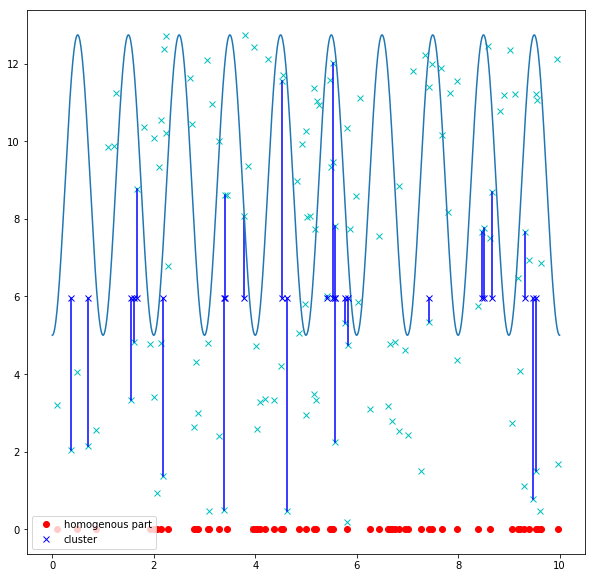

In [7]:
plt.figure(figsize = (10,10))
plt.plot(X[0,:], X[1,:], 'xc')
for event in inhom:
    pick = X[:,X[0,:] == event]
    plt.plot([event, pick[0]],[base_max,pick[1]], 'b')
plt.plot(time, inhomogenity(time, param[0],param[1]))
plt.plot(hom, np.zeros(len(hom)), 'ro', label = 'homogenous part')
plt.plot(inhom, base_max*np.ones(len(inhom)), 'bx', label = 'cluster')
plt.legend()
plt.show

## Estimation including longer axis with eccentricty

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound, minimize 
from scipy.integrate import quad

# Setup for intensity function

param = [5,1]

e = 0.1 # b/a
a = 20
flip = 1

if flip ==1:
    p_t_a = param[1]*a
    print(p_t_a)
    def inhomogenity_exc(time, base, peak_t_a): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak_t_a*(e + 1 - np.sqrt((e - np.cos(2*np.pi*(time-1/2)))**2 + (1-e**2)*(np.sin(2*np.pi*(time-1/2))**2)))
else:
    p_t_a = param[1]/a
    print(p_t_a)
    def inhomogenity_exc(time, base, peak_t_a): # goal in the end to estimate "base" and "peak". a and b are hyperparameters
        return base + peak_t_a/(np.sqrt((e - np.cos(2*np.pi*(time-1/2)))**2 + (1-e**2)*(np.sin(2*np.pi*(time-1/2))**2)))

# Analyis of inhomogenity
maximum_of_inhomogenity = fminbound(lambda x: -inhomogenity_exc(x, param[0], p_t_a), 0, 1)
z = inhomogenity_exc(maximum_of_inhomogenity, param[0], p_t_a)
t_max = 10
amount_of_dummy_realizations = int(t_max*z) + 1

# Create window to simulate IPP over 
X = np.random.rand(2, amount_of_dummy_realizations)
X = X[:,np.argsort(X[0,:])]
X[0,:] = X[0,:]*t_max
X[1,:] = X[1,:]*z 


hist = np.array([])
t_cur = 0

for item in X.T:
    if item[0] > t_cur:
        t_eval = item[0]
        if inhomogenity_exc(t_eval, param[0],p_t_a) > item[1]:
            hist = np.append(hist,t_eval)
            t_cur = t_eval
        else:
            t_cur = t_eval


20


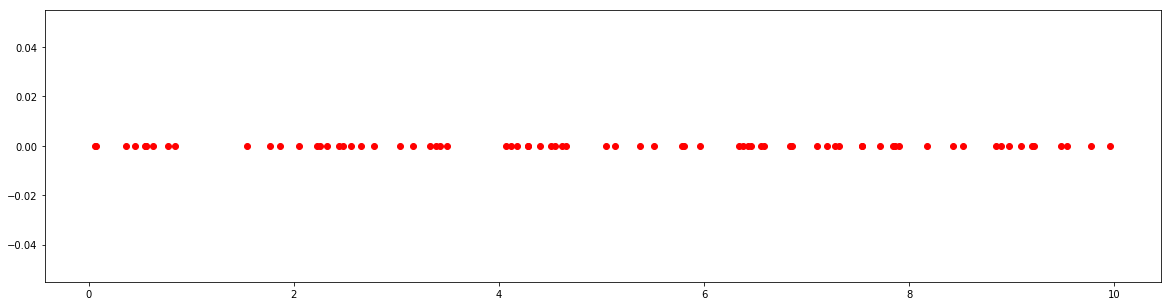

In [32]:
plt.figure(figsize = (20,5))
plt.plot(hist, np.zeros(len(hist)), 'ro')

In [33]:
def parameter_estimator(function, data):
    def negative_likelihood_function(parameters): # use equation sum lambda(x_i) - int lambda(x) dx
        parameter_a, parameter_b = parameters
        return -np.log(function(data, parameter_a, parameter_b)).sum() + int(t_max)*quad(lambda x: function(x, parameter_a, parameter_b),0,1)[0]
    max_likelihood_a, max_likelihood_b = minimize(negative_likelihood_function, [1,1], bounds = ((0, None), (0, None)))['x']
    return max_likelihood_a, max_likelihood_b

base_max, peak_max = parameter_estimator(inhomogenity_exc, hist)
print([base_max,peak_max])

[5.760941798136009, 18.39045257195167]


In [31]:
hom = []
inhom = []
for event in hist:
    u = np.random.rand()
    if u < (inhomogenity_exc(event,base_max, peak_max)-base_max)/inhomogenity_exc(event, base_max, peak_max):
        inhom.append(event)
    else:
        hom.append(event)